In [1]:
import importlib
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import healpix_utils

In [2]:
importlib.reload(healpix_utils)

<module 'healpix_utils' from '/home/m/m301021/add-CloudClimato-team/hk25-CloudClimato/healpix_utils.py'>

In [139]:
cat_hk25 = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")['EU']
cat_nextgems = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")["ICON"]

In [140]:
print(list(cat_hk25))

['ERA5', 'IR_IMERG', 'JRA3Q', 'MERRA2', 'casesm2_10km_nocumulus', 'icon_d3hp003', 'icon_d3hp003aug', 'icon_d3hp003feb', 'icon_ngc4008', 'ifs_tco3999-ng5_deepoff', 'ifs_tco3999-ng5_rcbmf', 'ifs_tco3999-ng5_rcbmf_cf', 'nicam_gl11', 'scream-dkrz', 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest', 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest', 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest', 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest', 'um_glm_n1280_CoMA9_TBv1p2', 'um_glm_n1280_GAL9', 'um_glm_n2560_RAL3p3']


In [142]:
print(list(cat_nextgems))

['ngc4008a', 'ngc4008', 'ngc4007', 'ngc4006', 'ngc4005', 'ngc3028', 'ngc3028_bc_land', 'ngc3026_WILL_BE_DELETED', 'HAMOCC', 'ngc3542', 'erc1011', 'erc1017', 'C5', 'PrecipPuzzle', 'ngc5004']


# Global variables

In [55]:
zoom = 6 # # https://easy.gems.dkrz.de/Processing/healpix/index.html 
deg = 1 # degree for regridded cell
idx = healpix_utils.get_nn_lon_lat_index(
    2**zoom, np.linspace(0+deg/2, 360-deg/2, int(360/deg)), 
    np.linspace(-90+deg/2, 90-deg/2, int(180/deg))
)

# ICON 

In [146]:
icon_simulations = {"ngc3028": {"long_name": "ICON cyc3"}, 
                    "icon_ngc4008": {"long_name": "ICON cyc4"},
              "icon_d3hp003": {"long_name": "ICON cyc5"}}

In [147]:
pd.DataFrame(cat_nextgems["ngc3028"].describe()["user_parameters"])

,name,description,type,allowed,default
0,time,time resolution of the dataset,str,"[PT30M, PT3H, P1D]",P1D
1,zoom,zoom resolution of the dataset,int,"[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",0


In [148]:
interesting_variables = ["tas", "prw", "clivi", #"cllvi",
                         "rsdt", "rsut",  "rlut"] 

In [153]:
for simu_name in icon_simulations.keys(): 
    if simu_name == "ngc3028": 
        cat = cat_nextgems 
    else: 
        cat = cat_hk25
    icon = cat[simu_name](zoom=zoom).to_dask()
    icon = icon[interesting_variables]
    icon = icon.sel(time=slice("2020-03-01", "2031-01-01")) # remove 1st 2 month spin-up 
    icon_toa = icon[['rlut', 'rsut']].isel(cell=idx).mean(["lon", "time"])
    icon_simulations[simu_name]['lat_profile'] = icon_toa

/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension nam

# ERA5

In [207]:
pd.DataFrame(cat_hk25["ERA5"].describe()["user_parameters"])

,name,description,type,allowed,default
0,zoom,zoom resolution of the dataset,int,"[8, 7, 6, 5, 4, 3, 2, 1, 0]",7


In [208]:
era5 = cat_hk25['ERA5'](zoom=zoom).to_dask()

/work/bb1153/m301021/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [209]:
interesting_variables = ["2t", "tcwv", "tcc", "tciw", "tclw",  "tisr", "tsr", "tsrc", "ttr", 'ttrc'] 

In [210]:
era5 = era5[interesting_variables]

In [211]:
era5 = era5.sel(time=slice("2003-01-01", "2024-01-1"))

In [213]:
era5_toa = era5.drop_vars(["lat", "lon"])[['ttr', 'tisr', 'tsr']].isel(cell=idx).mean(["lon", "time"])
era5_toa['tsr'] = era5_toa.tisr - era5_toa.tsr
era5_toa = era5_toa.rename({'tsr': 'rsut', 'ttr': 'rlut'})
era5_toa['rlut'] = - era5_toa.rlut / (3600*24) # to convert to W m-2
era5_toa['rsut'] = era5_toa.rsut / (3600*24) # to convert to W m-2

# CERES

In [237]:
ddir_ceres = '/pool/data/ICDC/atmosphere/ceres_ebaf/DATA/' # on Levante

In [238]:
ceres = xr.open_dataset(ddir_ceres + "CERES_EBAF-TOA_Edition4.2_ZONALMEAN_MONTHLY_CLIMATOLOGY.nc")

In [239]:
ceres = ceres[[
    "ztoa_sw_all_clim", "ztoa_lw_all_clim"]
].mean('ctime').rename(
    {"ztoa_sw_all_clim":"rsut", "ztoa_lw_all_clim": "rlut"})

# Compare

In [214]:
from matplotlib import colormaps

In [215]:
cmap = colormaps["Set2"]

In [250]:
v_dict = {'rlut': 'Outgoing Longwave Radiation\nOLR [W m$^{-2}$]', 
         'rsut': 'Reflected Shortwave Radiation\nRSW [W m$^{-2}$]'}

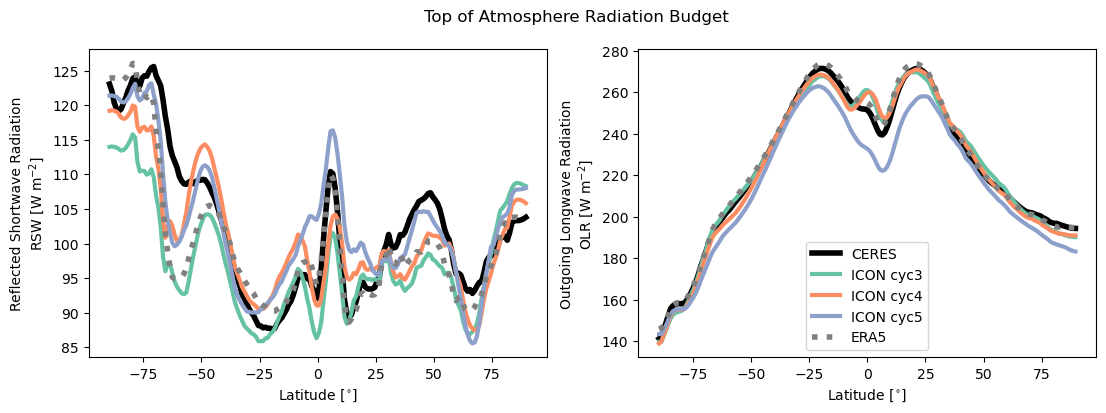

In [257]:
f,axes = plt.subplots(1,2, figsize=(13,4))

for v_id,v in enumerate(['rsut', 'rlut']): 
    ax = axes[v_id] 
    ceres[v].plot(ax=ax, lw=4, c='black', label='CERES')
    for i,simu_name in enumerate(list(icon_simulations.keys())):
        icon_simulations[simu_name]['lat_profile'][v].plot(ax=ax, lw=3, c=cmap(i), label=icon_simulations[simu_name]['long_name'])
    era5_toa[v].plot(ax=ax, lw=4, ls=":", c='grey', label='ERA5')
    ax.set_ylabel(v_dict[v]);
    ax.set_title('')
    ax.set_xlabel(r"Latitude [$^{\circ}$]")
ax.legend()
f.suptitle("Top of Atmosphere Radiation Budget");